In [143]:
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scirpy as ir
import numpy as np
import pathlib
import muon as mu
from muon import prot as pt
import os
import numpy as np
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0, "transparent": True}
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import celltypist
from celltypist import models
overload = False
if overload == True:
    output_dir='figures/overload'
else:
    output_dir = "figures/no_overload"

pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
output_suffix = ""
output_formats = [".png", ".svg"]
sc.settings.figdir = output_dir
sc.set_figure_params(dpi_save = 300)
sc.set_figure_params(format = 'png')
def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None


donor = 'TBD6'
data = '/home/michaelswift/repos/tabula-bursa/data/10X'
samples = ['LN', 'SPL', 'PBMC', 'BM']
prots = []
tenX_output = 'filtered'

def load_data(samplenames, data, donor, overload):
    """samplename is a list of samplenames / tissue names, 
    data is where the data were downloaded
    donor is the name of the donor
    all of these info are used to create the file path
    """
    
    for sample in samples:
        if tenX_output == 'raw':
            datapath = '{}/{}_{}/outs/multi/count/raw_feature_bc_matrix/'.format(data, donor, sample)
            print(datapath)
            prot = mu.read_10x_mtx(datapath)
            prots.append(prot)
            prot['prot'].obs['tissue'] = sample
        if tenX_output == 'filtered':
            datapath = '{}/{}_{}/outs/per_sample_outs/{}_{}/count/sample_feature_bc_matrix/'.format(data, donor, sample, donor ,sample)
            print(datapath)
            prot = mu.read_10x_mtx(datapath)
            prots.append(prot)
            prot['rna'].obs['tissue'] = sample
 
    adatas = []
    for prot in prots:
        adata = prot['rna']
        adatas.append(adata)
    if overload == True:
        analysis = "with_overload"
    else:
        analysis = "without_overload"
    if overload:
    # hard coded number of samples right now
        adata = adatas[0].concatenate(adatas[1], adatas[2], adatas[3], adatas[4], adatas[5], adatas[6], adatas[7])
    else:
        adata = adatas[0].concatenate(adatas[1], adatas[2], adatas[3])
    return adata
    
def perform_qc(adata):    
    # calculate qc metrics
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    adata = adata[:,~adata.var.index.str.contains('HSP|DNAJ')]
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)
    sc.pl.highest_expr_genes(adata,save='prefilter')
    # plot qc metrics
    sc.pl.violin(adata, ['n_genes_by_counts', 'log1p_total_counts', 'total_counts'], stripplot=False, multi_panel=True, save='prefilter')
    # cell filter
    sc.pp.filter_cells(adata, min_counts=800)
    sc.pp.filter_cells(adata, max_counts=40000)
    adata = adata[adata.obs['pct_counts_mt'] < 10]
    # plot results of filtering
    sc.pl.violin(adata, ['n_genes_by_counts', 'log1p_total_counts', 'total_counts'], stripplot=False, multi_panel=True, save='postfilter')
    sc.pl.highest_expr_genes(adata, save='postfilter')
    return adata

In [132]:
# create concatenated adata object
adata = load_data(samplenames=samples, data = data, donor=donor, overload=False)
# write for later use
adata.write_h5ad('/home/michaelswift/repos/tabula-bursa/data/processed_h5ad/full_object.h5ad')

/home/michaelswift/repos/tabula-bursa/data/10X/TBD6_LN/outs/per_sample_outs/TBD6_LN/count/sample_feature_bc_matrix/
/home/michaelswift/repos/tabula-bursa/data/10X/TBD6_SPL/outs/per_sample_outs/TBD6_SPL/count/sample_feature_bc_matrix/
/home/michaelswift/repos/tabula-bursa/data/10X/TBD6_PBMC/outs/per_sample_outs/TBD6_PBMC/count/sample_feature_bc_matrix/
/home/michaelswift/repos/tabula-bursa/data/10X/TBD6_BM/outs/per_sample_outs/TBD6_BM/count/sample_feature_bc_matrix/


... storing 'tissue' as categorical
... storing 'feature_types' as categorical


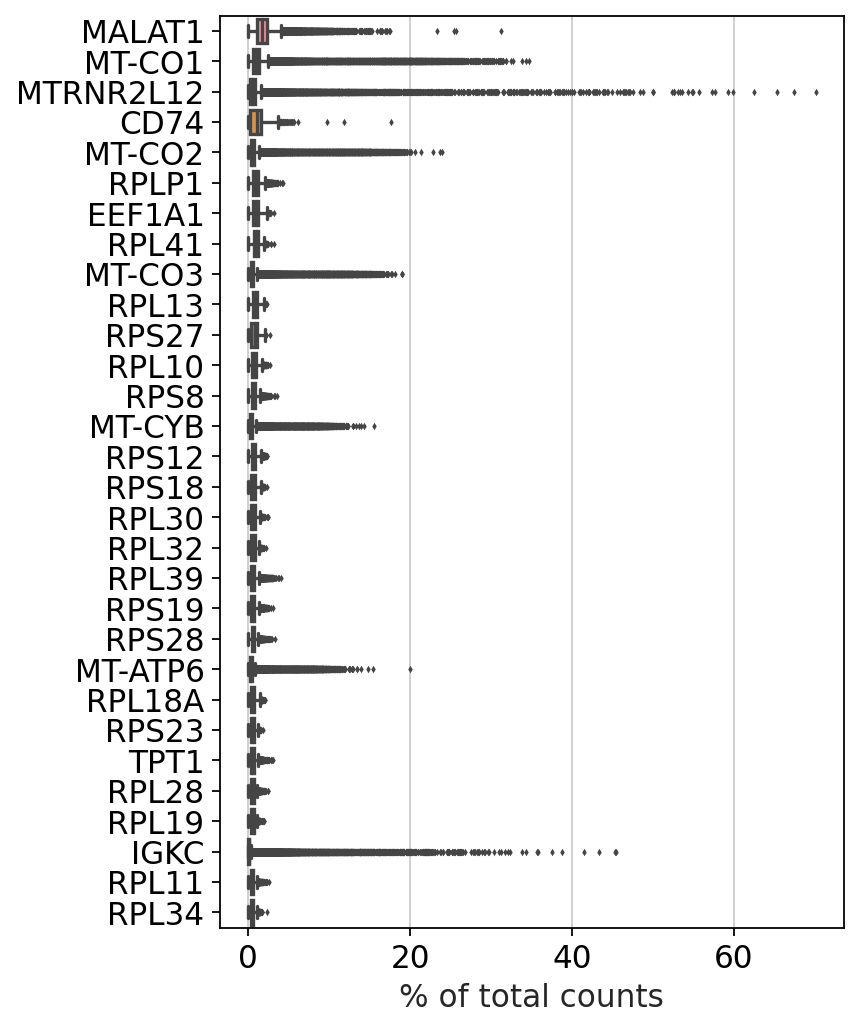

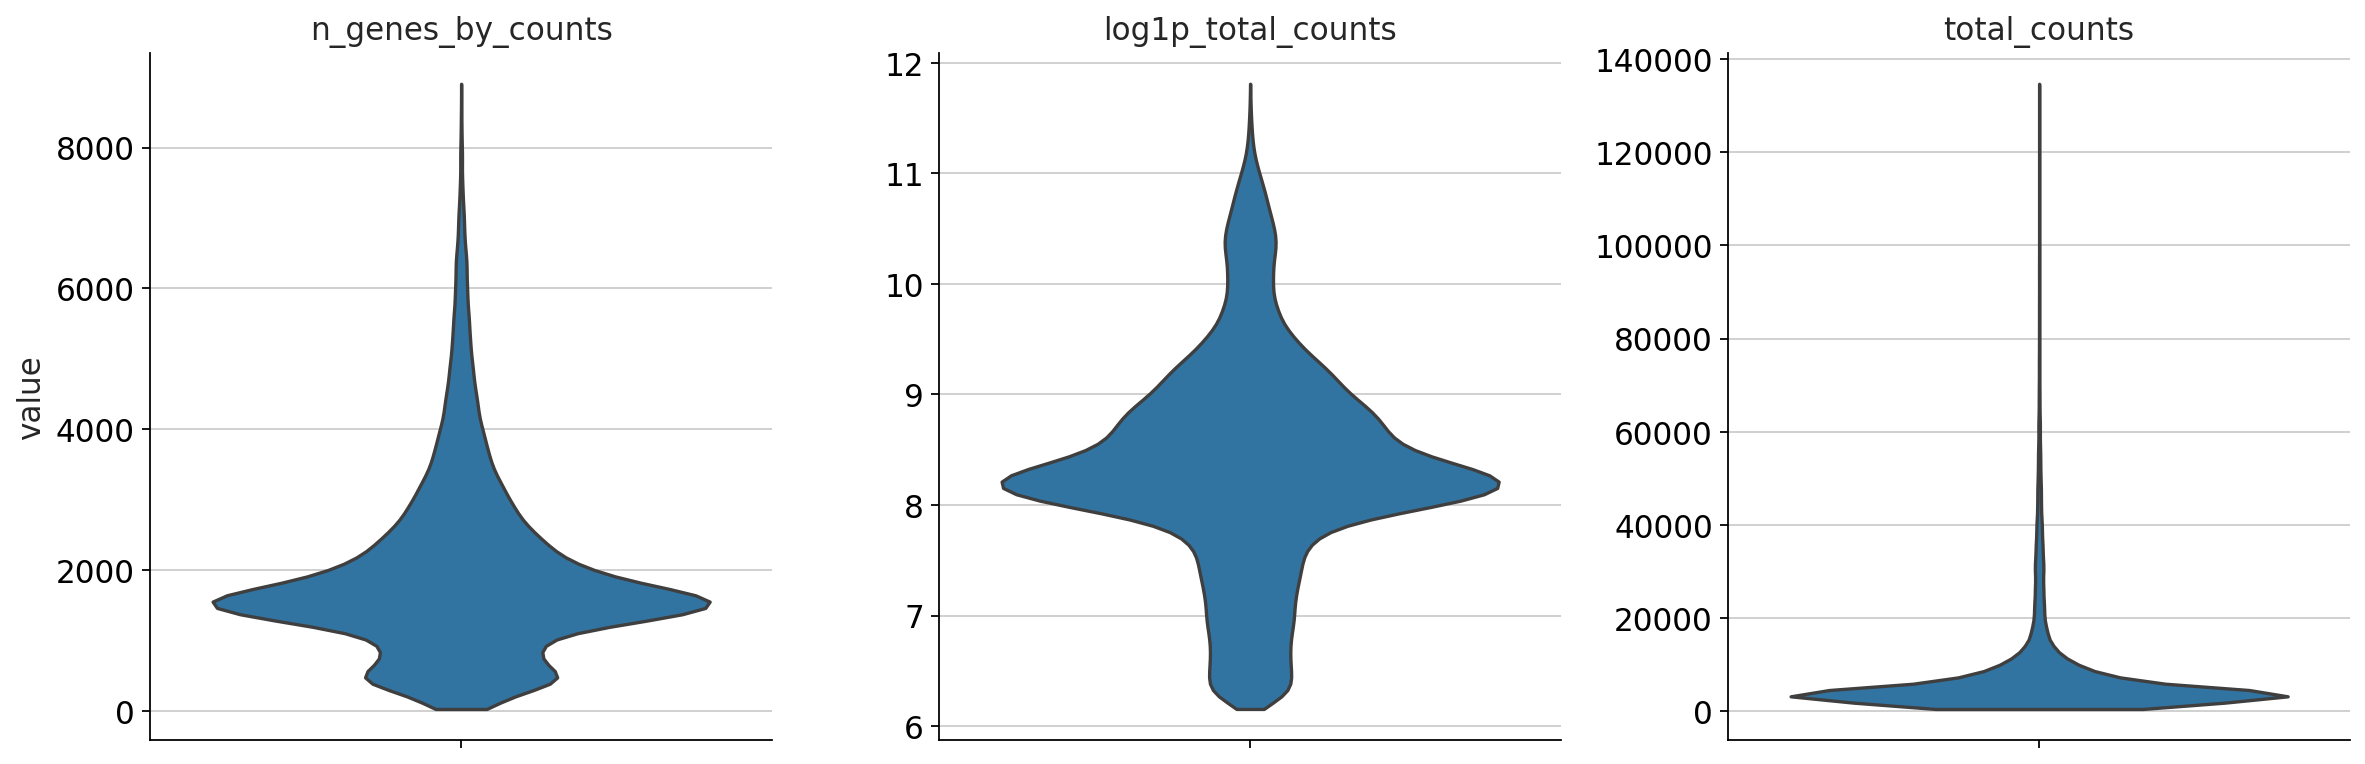

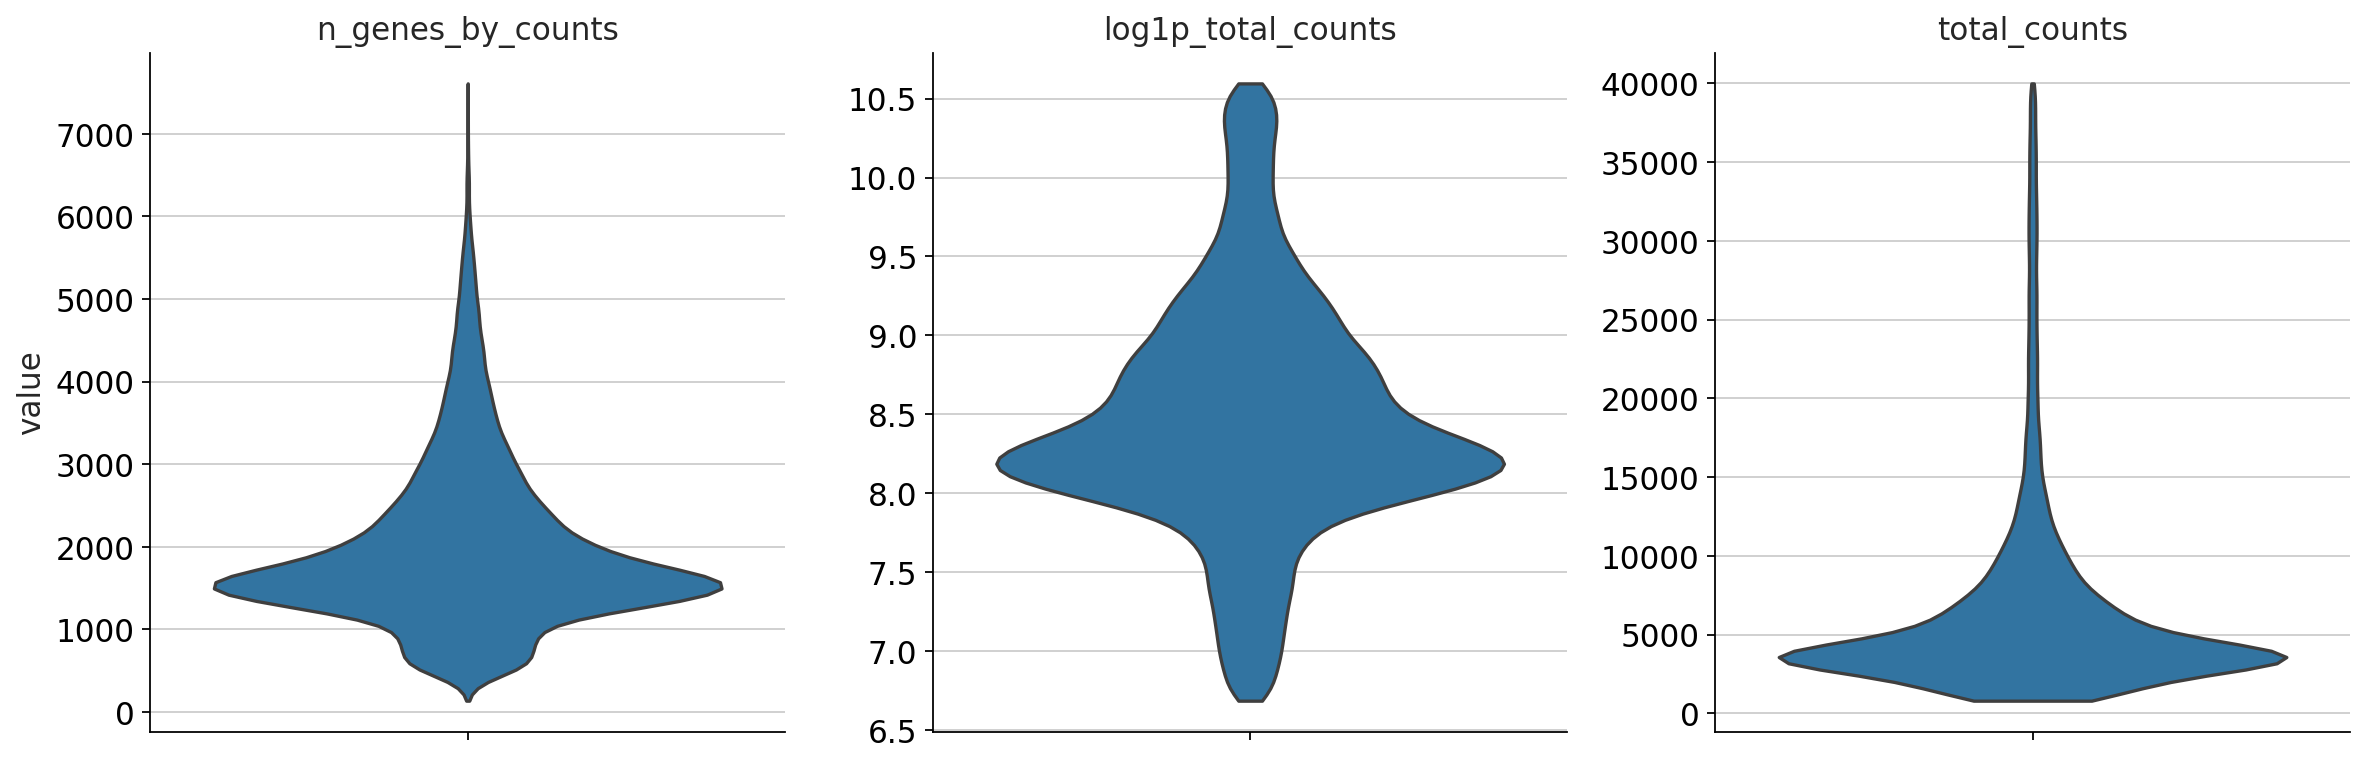

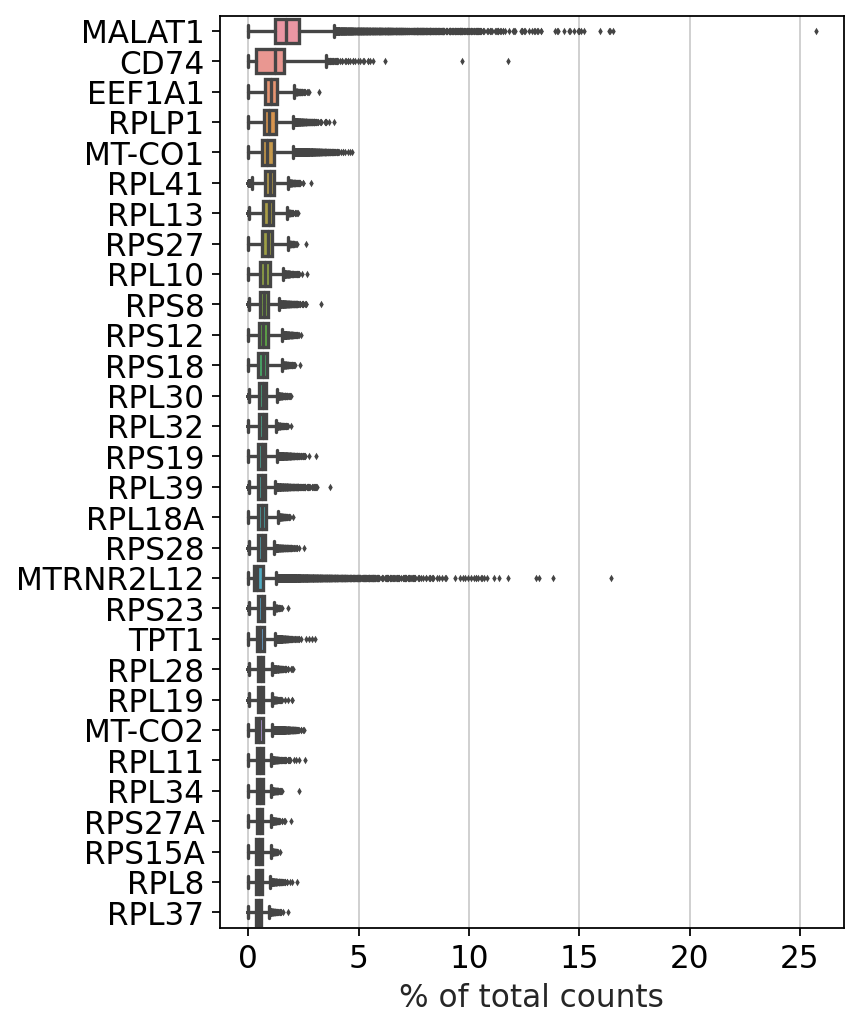

In [144]:
adata = sc.read_h5ad('../../data/processed_h5ad/full_object.h5ad')
adata = perform_qc(adata)

In [145]:
adata.obs.shape

(58157, 10)

In [3]:
def tissue_colors():
    
    tissue_color_dict = {
             'PBMC': '#d6616b',
             'BM': '#cedb9c',
             'LN': '#8c6d31',
             'SPL': '#393b79'}
    return tissue_color_dict

In [4]:
rna = adata

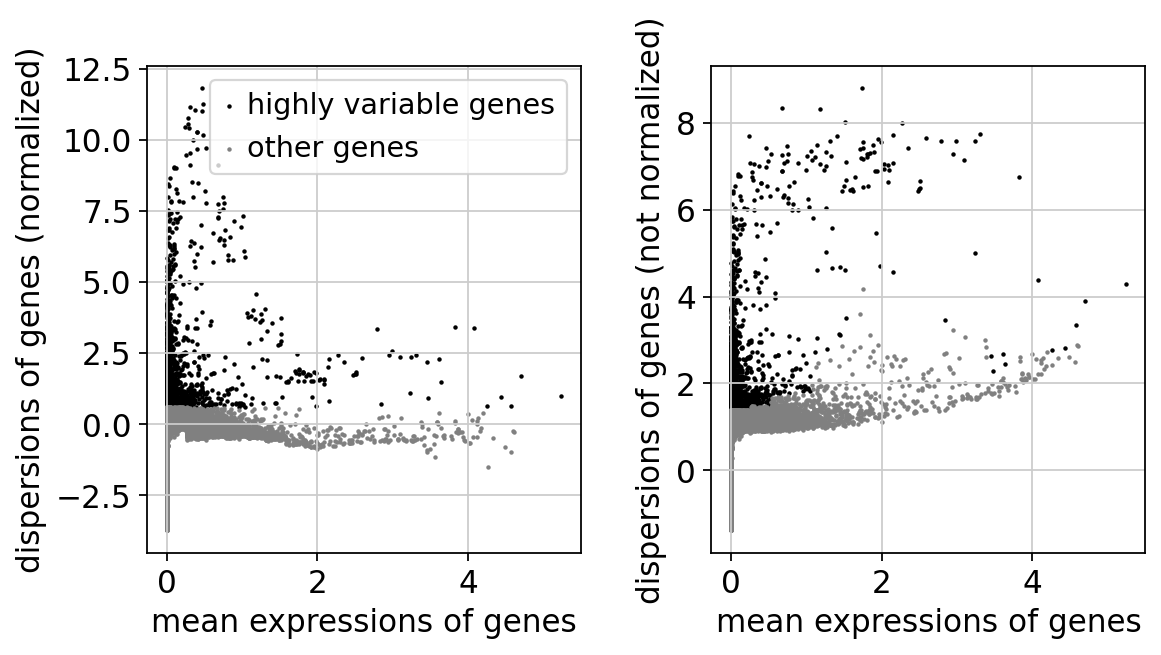

In [5]:
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna, base = 2)
sc.pp.highly_variable_genes(rna, n_top_genes=4000)
sc.pl.highly_variable_genes(rna)
rna.raw = rna
sc.pp.scale(rna, max_value = 10)

In [6]:
rna.var.loc[rna.var.index.str.contains("IGHV|IGLV|IGKV"), 'highly_variable'] = False

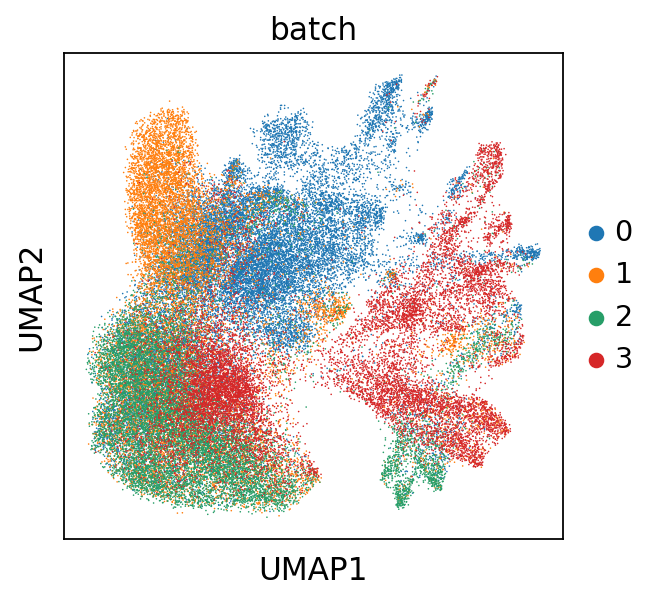

In [7]:
def recluster(adata, batch_correct, batch_key):
    sc.pp.pca(adata)
    if batch_correct == True:
        sce.pp.bbknn(adata, batch_key=batch_key)
    else:
        sc.pp.neighbors(adata, n_neighbors=20)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.2)
    sc.pl.umap(adata, color = 'batch')
    return adata
rna = recluster(rna, batch_correct=True, batch_key = 'tissue')

# Label the cells with celltypist

In [8]:

#Download all the available models.
#models.download_models()
#Update all models by re-downloading the latest versions if you think they may be outdated.
#models.download_models(force_update = True)

#Provide the input as an `AnnData`.
#predictions = celltypist.annotate('data/bcells.h5ad', model = 'Immune_All_Low.pkl', majority_voting=True)
#Alternatively, the input can be specified as an `AnnData` already loaded in memory.
predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl', majority_voting=True)
# Celltypist Annotations to bcells object
adata.obs['celltypist'] = predictions.predicted_labels.majority_voting

👀 Detected scaled expression in the input data, will try the `.raw` attribute
🔬 Input data has 58157 cells and 36518 genes
🔗 Matching reference genes in the model
🧬 6117 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!


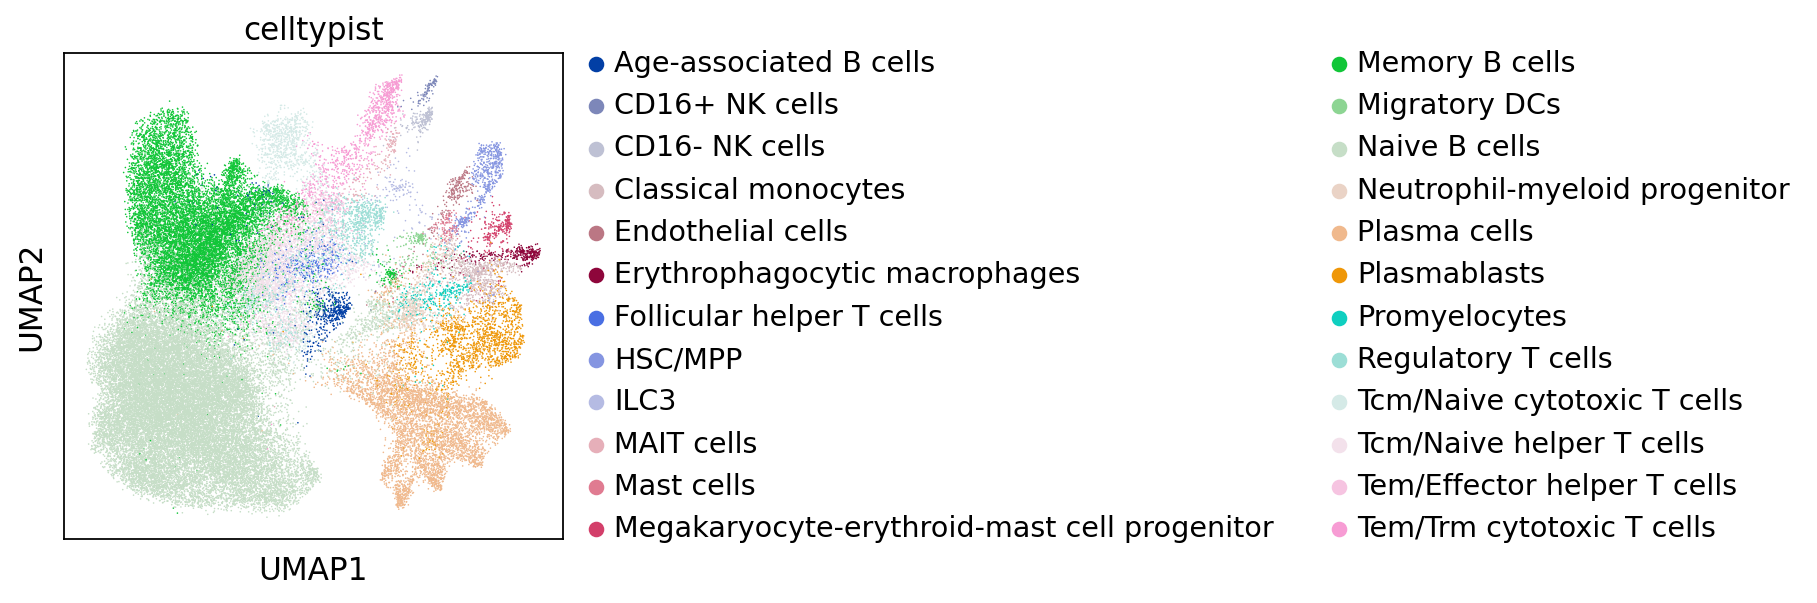

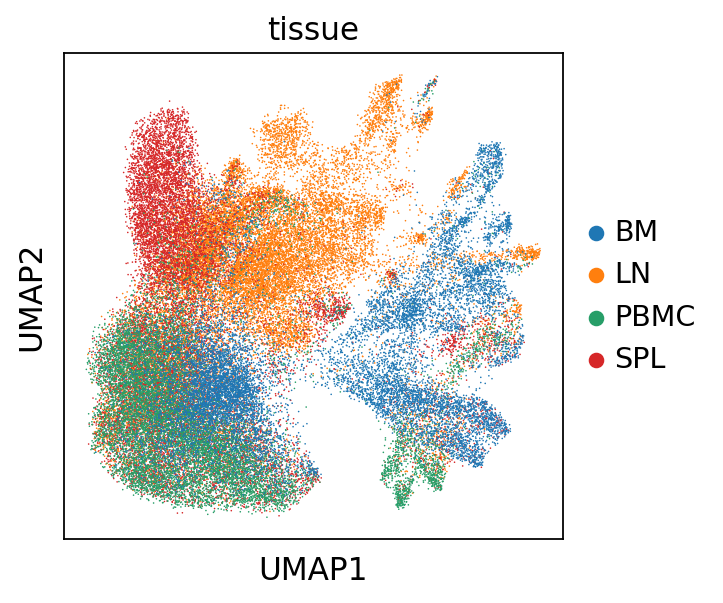

In [9]:
sc.pl.umap(adata, color = 'celltypist')
sc.pl.umap(adata, color = 'tissue')

# cell proportions by tissue

Text(0, 0.5, 'sample_id')

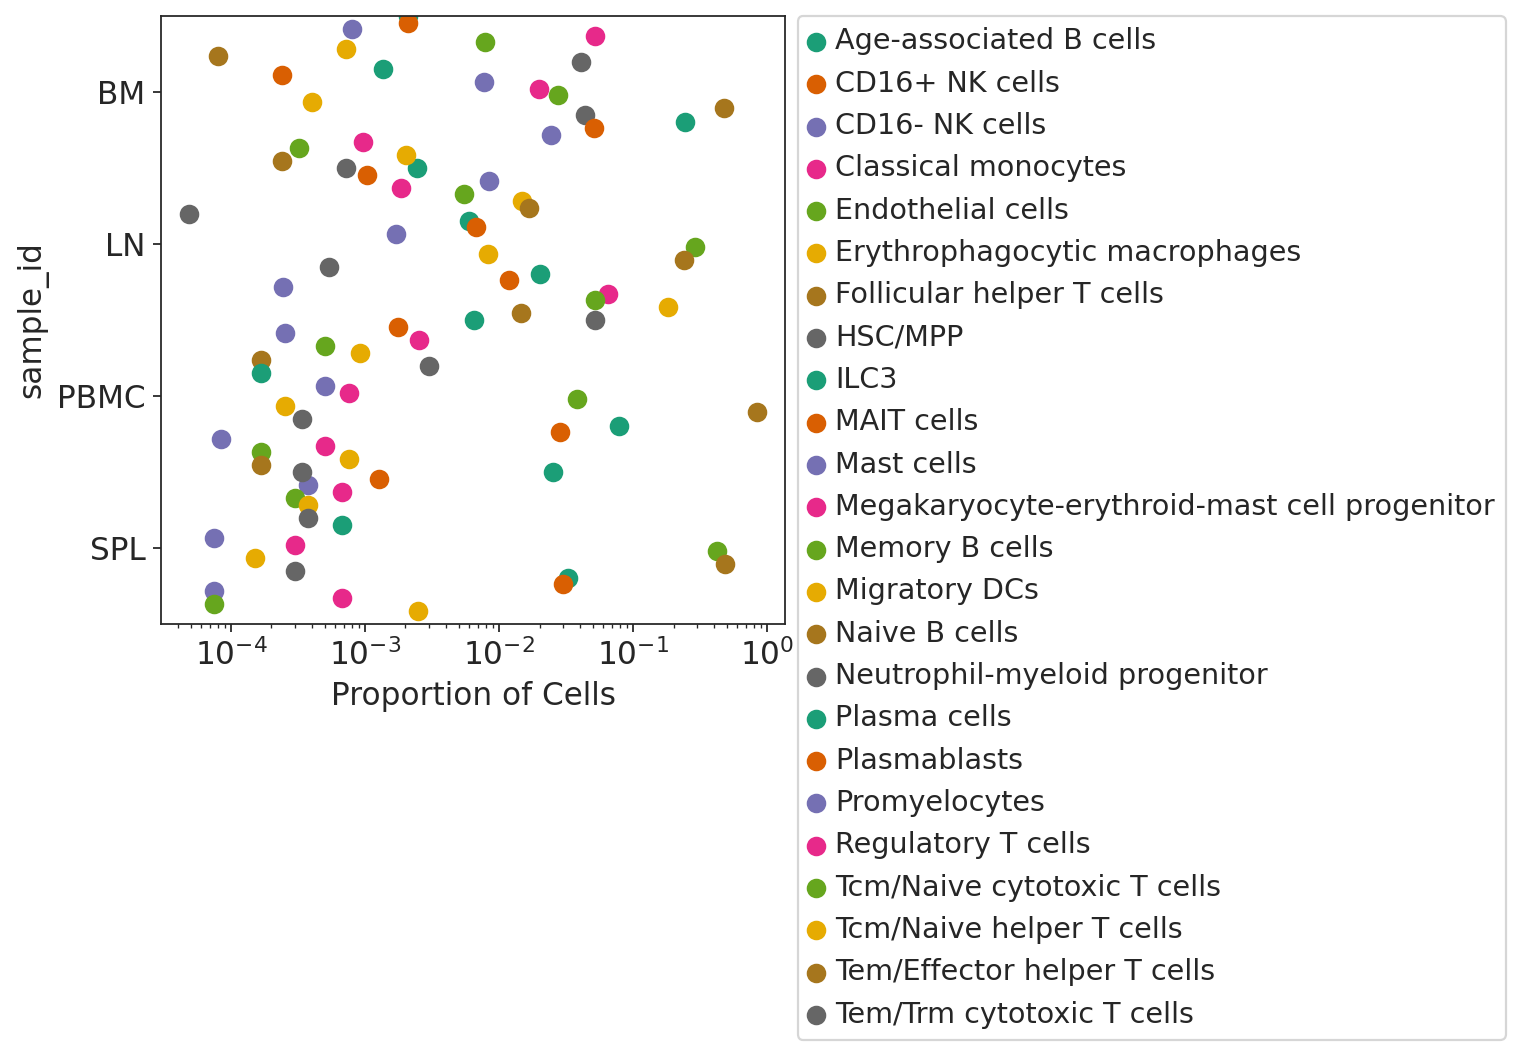

In [10]:
group = "tissue"
label = "celltypist"
color = label
data = pd.DataFrame(rna.obs.groupby([group])[label].value_counts(normalize=True))
data.columns = ["dummy"]
data.reset_index(inplace=True)
data.columns = ["sample_id", "celltype", "proportion"]
sns.axes_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(5,5))

sns.pointplot(
    y="sample_id",
    x="proportion",
    hue="celltype",
    data=data,join = False, dodge=1, palette='Dark2')

plt.xscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.xlabel("Proportion of Cells")
plt.ylabel("sample_id")

# cell proportions by tissue

## subsetting to cell types which represent more than 3% of the population

In [60]:
sub_data = data[data.proportion > 0.03]
sub_data.celltype = sub_data.celltype.cat.remove_unused_categories()
sns.axes_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(5,5))

sns.barplot(
    y="sample_id",
    x="proportion",
    hue="celltype",
    data=sub_data,)

#plt.xscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.xlabel("Proportion of Cells")
plt.ylabel("sample_id")


fig, ax = plt.subplots(1, 1, figsize=(5,5))

sns.pointplot(
    y="sample_id",
    x="proportion",
    hue="celltype",
    data=sub_data,join = False, dodge=0.2, palette='Dark2')

plt.xscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.xlabel("Proportion of Cells")
plt.ylabel("sample_id")


AttributeError: 'DataFrame' object has no attribute 'proportion'

# proportion of age-associated B cells per tissue, normalize to total B lineage


In [16]:
data = adata.obs

In [17]:
sub_data = data[data.celltypist.str.contains('B cell|Plasma')].groupby('tissue').celltypist.value_counts(normalize = True).unstack()

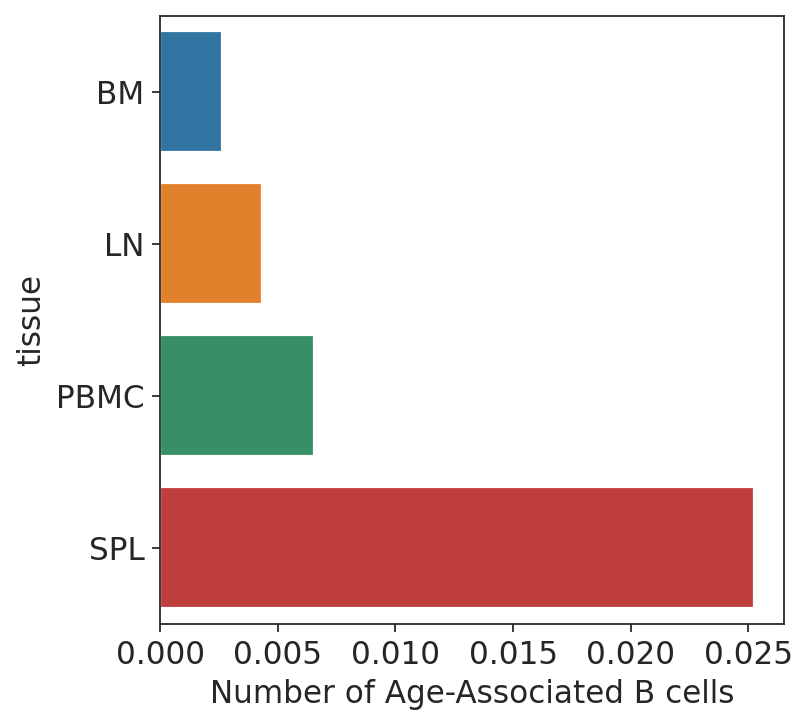

In [18]:
## Age associated B-cells:
adata = rna
group = "tissue"
data = adata.obs
sub_adata = data[data.celltypist == 'Age-associated B cells']
#
fig, ax = plt.subplots(1, 1, figsize=(5,5))

sns.barplot(y = sub_data.index, x = sub_data['Age-associated B cells'])
plt.xlabel("Proportion of Age-Associated B cells")
save_figure(fig, "number_of_age_associated_b_cells_{}".format(group))


# Are these Bona-fide Age-Associated B cells?

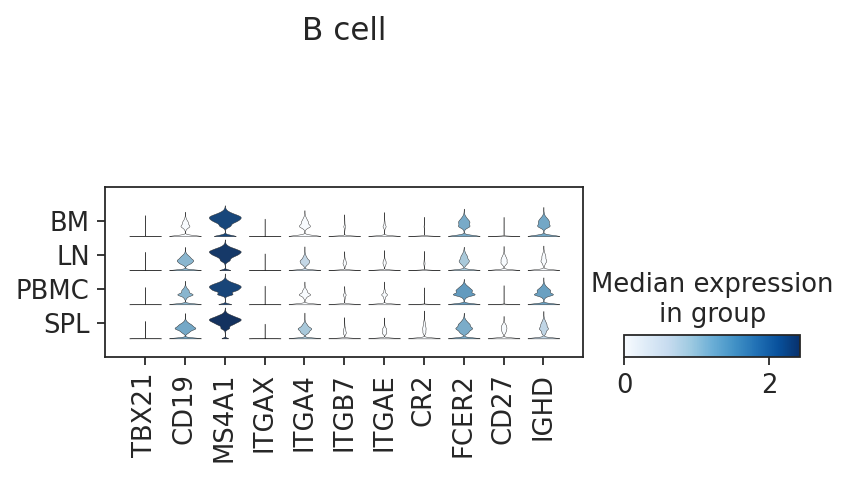

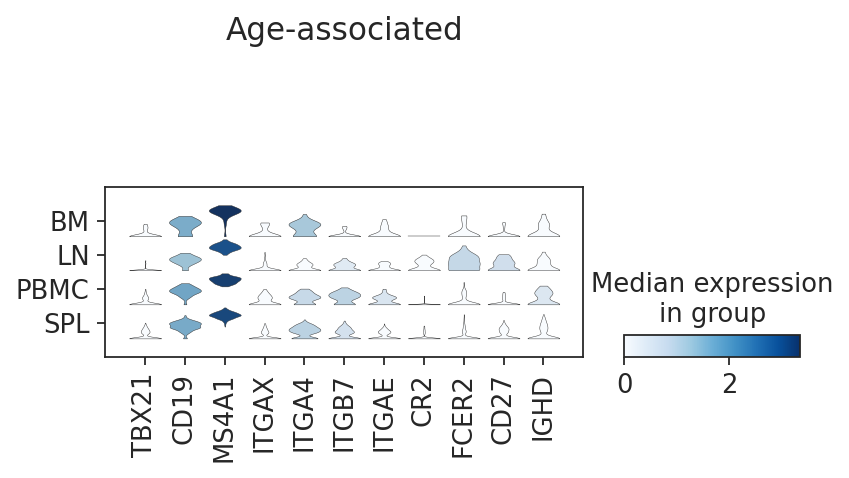

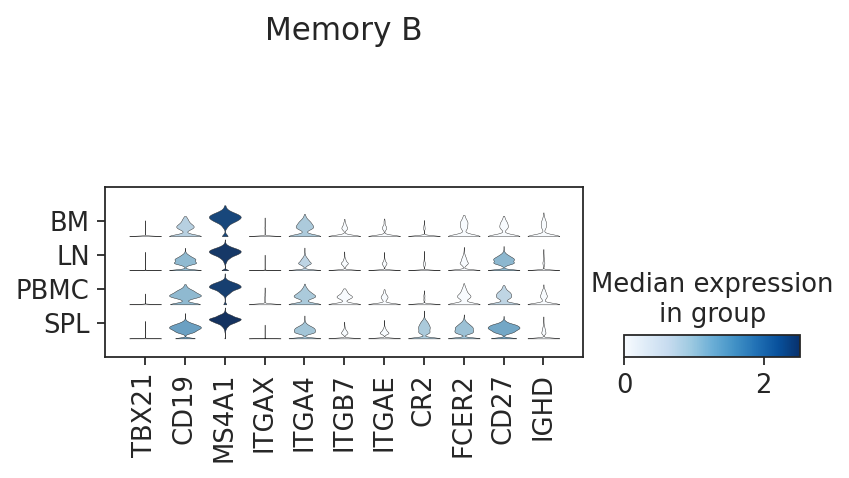

In [24]:
subset = 'B cell'
gene_set = ['TBX21', 'CD19', 'MS4A1', 'ITGAX', 'ITGA4', 'ITGB7', 'ITGAE', 'CR2', 'FCER2', 'CD27', 'IGHD']
sub_adata = adata[adata.obs.celltypist.str.contains(subset)]
#print('Stacked Violin of B cell markers')
sc.pl.stacked_violin(sub_adata, var_names=gene_set, groupby='tissue', title = subset)

subset = 'Age-associated'
sub_adata = adata[adata.obs.celltypist.str.contains(subset)]
#print('Stacked Violin of Memory B cell markers')
sc.pl.stacked_violin(sub_adata, var_names=gene_set, groupby='tissue', title = subset)


#print('Stacked Violin of Age associated')
subset = 'Memory B'
sub_adata = adata[adata.obs.celltypist.str.contains(subset)]

sc.pl.stacked_violin(sub_adata, var_names=gene_set, groupby='tissue', title = subset)

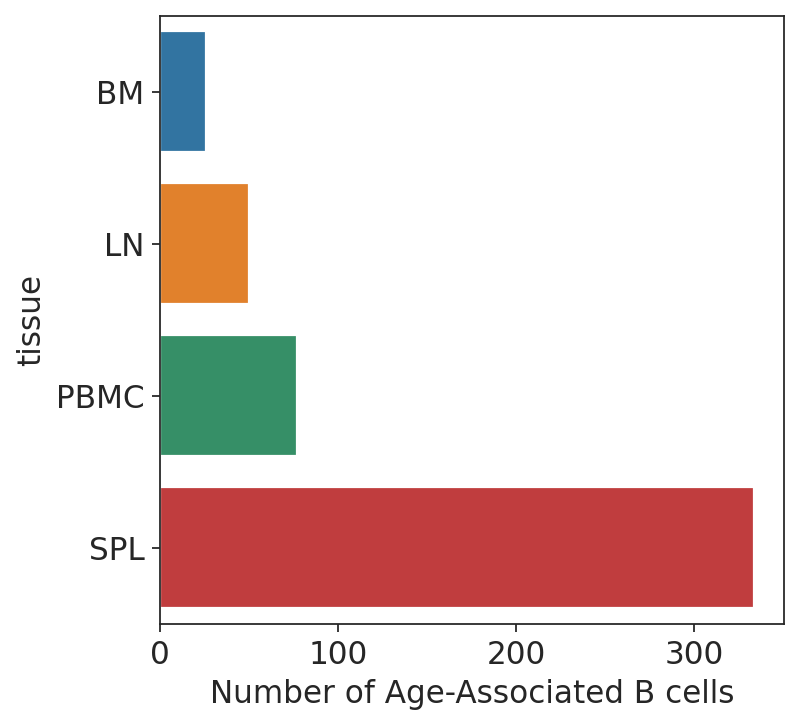

In [20]:
## Age associated B-cells:
adata = rna
group = "tissue"
data = adata.obs
sub_adata = data[data.celltypist == 'Age-associated B cells']

fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.countplot(y=group, data=sub_adata)
plt.xlabel("Number of Age-Associated B cells")
save_figure(fig, "number_of_age_associated_b_cells_{}".format(group))

# cells per tissue

In [ ]:
adata = rna
group = "tissue"
data = adata.obs
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.countplot(y=group, data=data)
plt.xlabel("Number of Cells")
save_figure(fig, "number_of_cells_{}".format(group))

# differential expression between same cell type, different tissue

## First I'll blacklist genes which are differentially expressed between the tissues in general

In [ ]:
print("performing differential expression analysis")
label = 'celltypist'
min_fold_change = 1
# uses t-test for speed, but wilcoxon is the more appropriate test I'm told
sc.tl.rank_genes_groups(adata, groupby=label)
sc.tl.filter_rank_genes_groups(adata, min_fold_change=min_fold_change)
print("filtered genes by min fold change {}".format(min_fold_change))

In [ ]:
sc.pl.rank_genes_groups(adata)

In [ ]:
result = adata.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names
gene_df = pd.DataFrame(
    {group + '_' + key[:]: result[key][group]
     # Get Each Clusters 10 top Genes
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})

# select non B cells
columns = pd.Series(gene_df.columns)
non_b = columns[~columns.str.contains('B cell|Plasma cell')]
gene_df = gene_df[non_b]

# select gene name column
columns = pd.Series(gene_df.columns)
names = columns[columns.str.contains('name')]
gene_df = gene_df[names]

# top 20 genes for each cell type
blacklisted = pd.Series(gene_df.iloc[:60].values.flatten())
blacklisted.unique().shape

In [ ]:
cell_type = 'Plasma cells'
label = 'tissue'
cell_label = 'celltypist'

_sub_adata = adata[adata.obs[cell_label] == cell_type]
# remove blacklisted genes
_sub_adata = _sub_adata[:,~_sub_adata.var.index.isin(blacklisted)]
print("{} {} in the dataset".format(_sub_adata.obs.shape[0], cell_type))

# subset to tissues with more than 10 cells detected in this class
# for reasonable differential epxression comparison
_df = pd.DataFrame(_sub_adata.obs.groupby(label)[cell_label].value_counts() > 10)
_tissues = _df[_df[cell_label] == True].unstack().index.to_list()
_sub_adata = _sub_adata[_sub_adata.obs.tissue.isin(_tissues)]
print("{} {} in the dataset {}".format(_sub_adata.obs.shape[0], cell_type, "after filtering out low abundance tissues"))

In [ ]:
print("performing differential expression analysis")
min_fold_change = 2
# uses t-test for speed, but wilcoxon is the more appropriate test I'm told
sc.tl.rank_genes_groups(_sub_adata, groupby=label)
sc.tl.filter_rank_genes_groups(_sub_adata, min_fold_change=min_fold_change)
print("filtered genes by min fold change {}".format(min_fold_change))

In [ ]:
sc.pl.rank_genes_groups(_sub_adata)

In [ ]:
sc.pl.rank_genes_groups_dotplot(_sub_adata)

In [ ]:
result = _sub_adata.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names
gene_df = pd.DataFrame(
    {group + '_' + key[:]: result[key][group]
     # Get Each Clusters 10 top Genes
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})

In [ ]:
holo_gene_set = []
num_genes = 20
result = _sub_adata.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names
gene_df = pd.DataFrame(
    {group + '_' + key[:]: result[key][group]
     # Get Each Clusters 10 top Genes
    for group in groups for key in ['names', 'pvals']})

tissue_colors_dictionary = tissue_colors()
#iterate thru the unique tissues
for tis in _sub_adata.obs[label].unique():

    # reset rank genes df for new organ
    _gene_df = gene_df.copy()
     # Drop the filtered genes
    _gene_df = _gene_df[[tis + '_names', tis + '_pvals']].dropna()
    gene_list = _gene_df[tis + '_names'].to_list()
    genes = gene_list
    holo_gene_set.append(gene_list)
    score_name = tis + '_' + cell_type + "_residence_score"
    sc.tl.score_genes(_sub_adata, gene_list = gene_list[:num_genes], score_name = score_name, use_raw = False)
    plotdf = sc.get.obs_df(
            _sub_adata,
            keys=genes + [label, score_name])
    for gene in genes[:2]:
        g = sns.displot(data = plotdf, x = gene, hue = label, kind='ecdf', palette=tissue_colors_dictionary
                   )
        g.set_titles(cell_type)
        g.set_xlabels(gene + ' expression')
        directory = 'figures/{}_specific/{}_{}/'.format(label, cell_type, tis)
        if not os.path.exists(directory):
            os.makedirs(directory)
        g.savefig('figures/{}_specific/{}_{}/{}.pdf'.format(label, cell_type, tis, gene))
    g = sns.displot(data = plotdf, x=score_name, hue = label, kind = 'ecdf', palette=tissue_colors_dictionary )
    g.savefig('figures/{}_specific/{}.pdf'.format(label, score_name))

## Integrating the VeeDeeJays


In [133]:
df = pd.read_table('../../../shared_data/cell_calls_full/TBD6_called_cells_combined_vdjc_lineage_ids_vseq_germ_blast.tsv.gz')

In [138]:
adata = sc.read_h5ad('/home/michaelswift/repos/tabula-bursa/data/processed_h5ad/full_object.h5ad')

In [139]:
adata.obs.shape

(67459, 2)

In [136]:
# construct merge columns
adata.obs['cb_index']=adata.obs.index
adata.obs['cb'] = adata.obs['cb_index'].str.split('-', expand=True)[0]
adata.obs['cb_sample_id'] = adata.obs['cb'].astype(str) + '_' + adata.obs['tissue'].astype(str)
df['cb_sample_id'] = df['cb'] + '_' + df['sample_id']
# PBL vs PBMC
df['cb_sample_id'] = df['cb_sample_id'].str.replace('PBL', 'PBMC')

In [137]:
print(adata.obs.shape[0], "cells in GEX dataset")

67459 cells in GEX dataset


### Seems there's multiple vdj's per cb

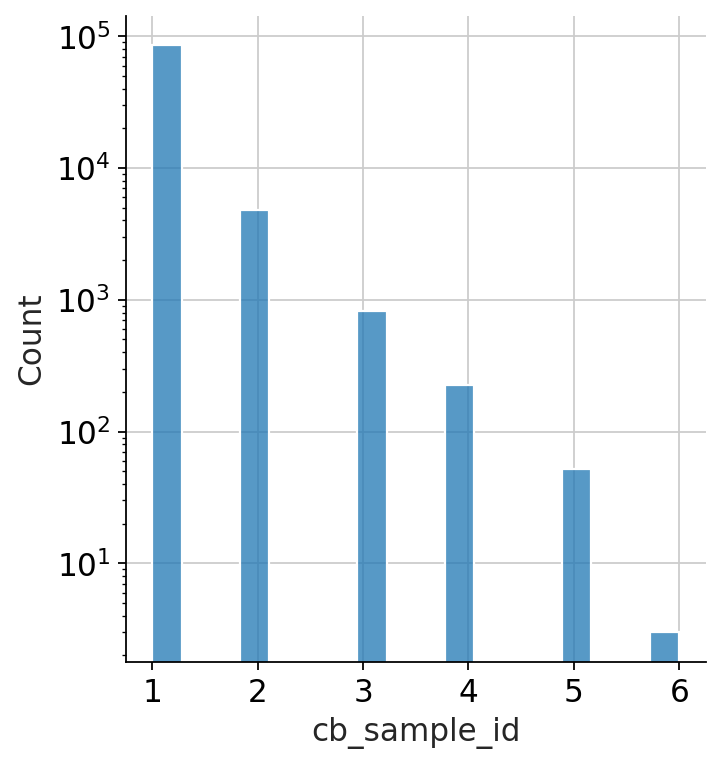

In [124]:
sns.displot(df.cb_sample_id.value_counts())
plt.yscale('log')

In [125]:
print(df.shape[0], "vdj / cbs")
print(df.drop_duplicates('cb_sample_id').shape[0], "single vdj with single cb")
print('dropping multiple vdj cbs')
df = df.drop_duplicates('cb_sample_id')
print('merging vdjs gex')
merged = pd.merge(adata.obs, df, left_on='cb_sample_id', right_on='cb_sample_id')
print(merged.shape[0], "cells after merging VDJs")

99196 vdj / cbs
91863 single vdj with single cb
dropping multiple vdj cbs
merging vdjs gex
33792 cells after merging VDJs


In [52]:
merged.set_index('cb_index', inplace=True)

In [53]:
adata = adata[adata.obs.index.isin(merged.index)]
#merged = merged[merged.index.isin(adata.obs.index)]

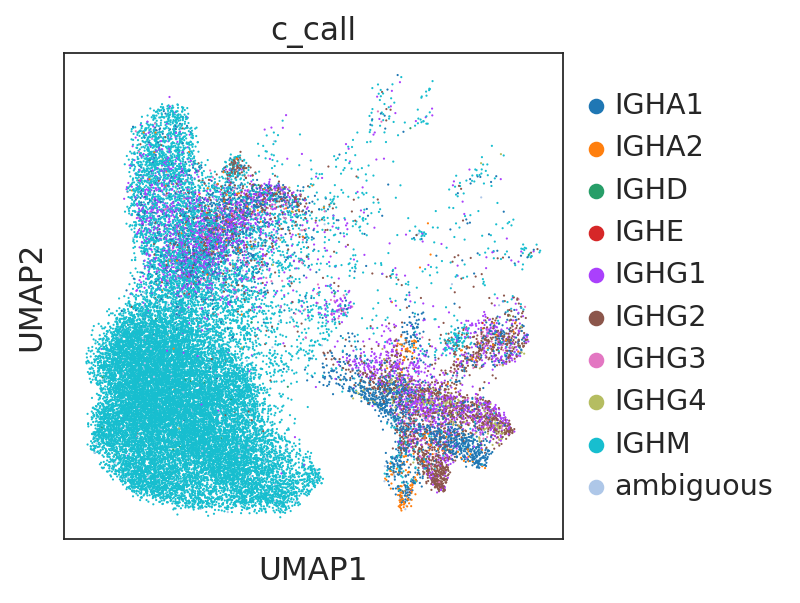

In [61]:
sc.pl.umap(adata, color = 'c_call')

In [62]:
adata.obs.celltypist = adata.obs.celltypist.cat.remove_unused_categories()

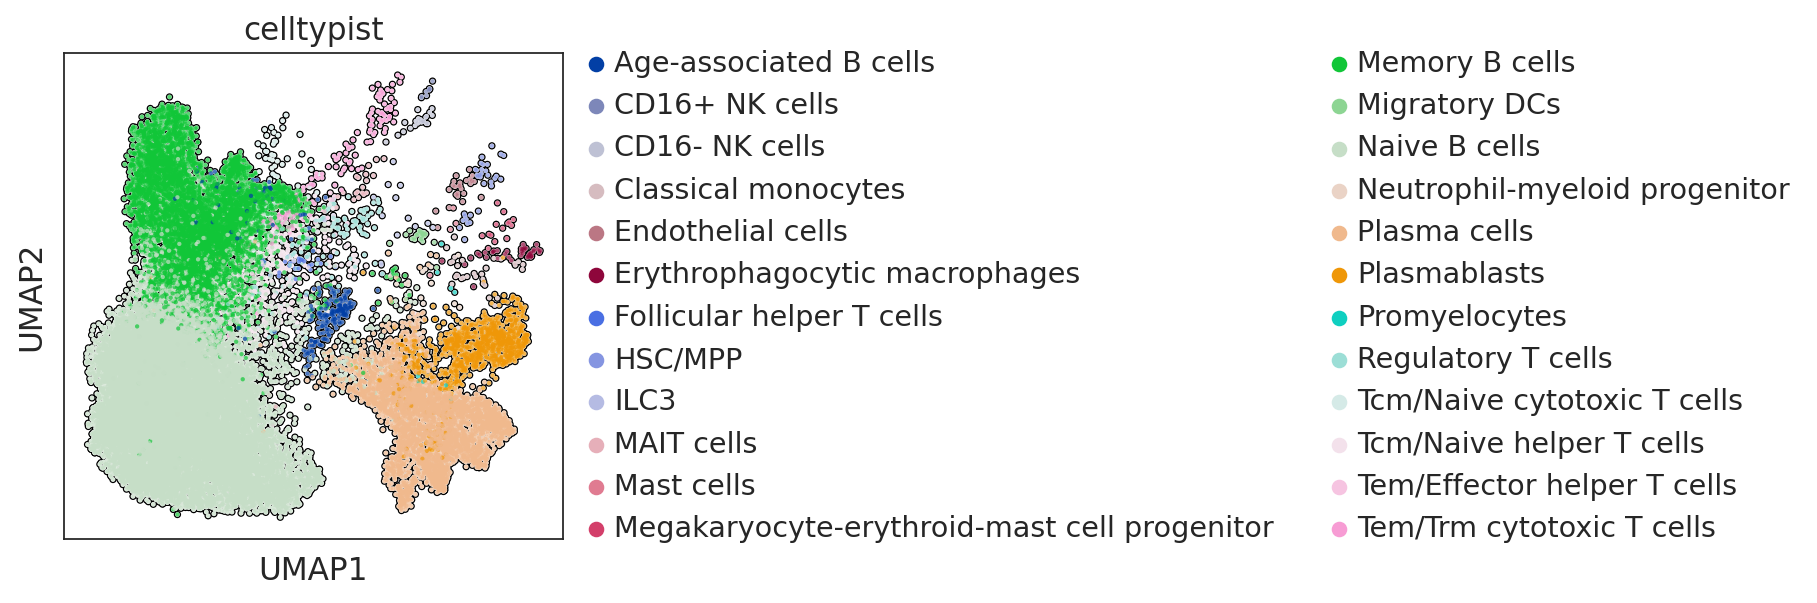

In [63]:
sc.pl.umap(adata, color = 'celltypist', size=15, add_outline=True)

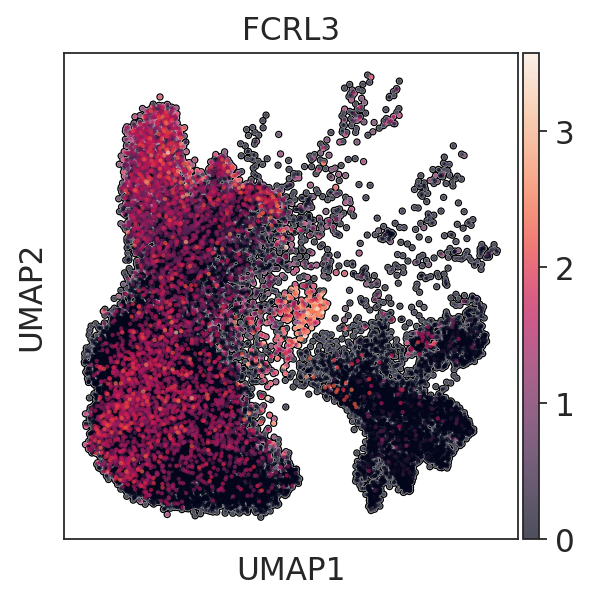

In [36]:
sc.pl.umap(adata, color = 'FCRL3', size=15, add_outline=True)

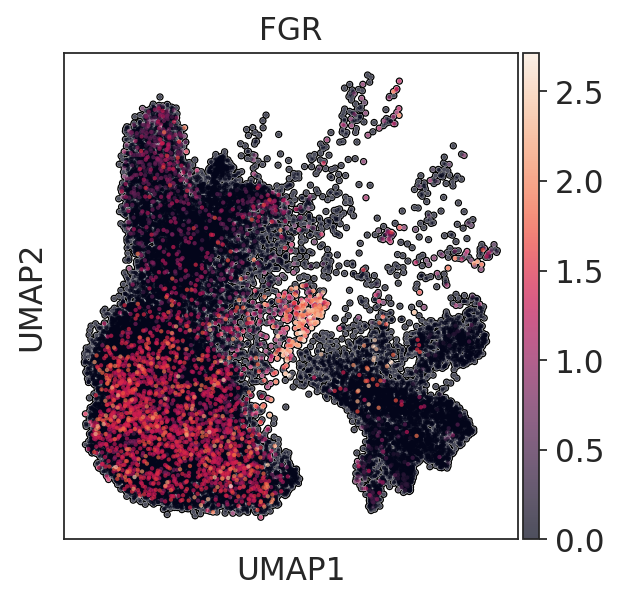

In [37]:
sc.pl.umap(adata, color = 'FGR', size=15, add_outline=True)

In [38]:
biglins = adata.obs.lineage_id.value_counts().index[:10]

In [43]:
adata.obs["clone_id"] = adata.obs.lineage_id

In [117]:
adata.obs.n

tissue batch  n_genes_by_counts  log1p_n_genes_by_counts  \
cb_index                                                                        
AAACCTGAGAAAGTGG-1-0     LN     0               2810                 7.941296   
AAACCTGAGACTAAGT-1-0     LN     0               1694                 7.435438   
AAACCTGAGAGGTAGA-1-0     LN     0               2651                 7.883069   
AAACCTGAGATGGCGT-1-0     LN     0               1518                 7.325808   
AAACCTGAGTAACCCT-1-0     LN     0               2593                 7.860956   
...                     ...   ...                ...                      ...   
TTTGTCAGTTGCGCAC-1-3     BM     3                532                 6.278521   
TTTGTCATCTCCAACC-1-3     BM     3               3494                 8.159089   
TTTGTCATCTCCCTGA-1-3     BM     3               4233                 8.350902   
TTTGTCATCTCTGCTG-1-3     BM     3               1901                 7.550661   
TTTGTCATCTTTACGT-1-3     BM     3               1815                 7.504392   

                      total_counts  log1p_total_counts  total_counts_mt  \
cb_index                                                                  
AAACCTGAGAAAGTGG-1-0        9524.0            9.161675            317.0   
AAACCTGAGACTAAGT-1-0        4284.0            8.362876            162.0   
AAACCTGAGAGGTAGA-1-0        7219.0            8.884610            301.0   
AAACCTGAGATGGCGT-1-0        3441.0            8.143808            100.0   
AAACCTGAGTAACCCT-1-0        6877.0            8.836083            497.0   
...                            ...                 ...              ...   
TTTGTCAGTTGCGCAC-1-3        1266.0            7.144407             61.0   
TTTGTCATCTCCAACC-1-3       35856.0           10.487294            340.0   
TTTGTCATCTCCCTGA-1-3       29739.0           10.300248           1221.0   
TTTGTCATCTCTGCTG-1-3        4533.0            8.419360            152.0   
TTTGTCATCTTTACGT-1-3        3898.0            8.268476            142.0   

                      log1p_total_counts_mt  pct_counts_mt  n_counts  ...  \
cb_index                                                              ...   
AAACCTGAGAAAGTGG-1-0               5.762052       3.328433    9524.0  ...   
AAACCTGAGACTAAGT-1-0               5.093750       3.781513    4284.0  ...   
AAACCTGAGAGGTAGA-1-0               5.710427       4.169552    7219.0  ...   
AAACCTGAGATGGCGT-1-0               4.615120       2.906132    3441.0  ...   
AAACCTGAGTAACCCT-1-0               6.210600       7.226989    6877.0  ...   
...                                     ...            ...       ...  ...   
TTTGTCAGTTGCGCAC-1-3               4.127134       4.818326    1266.0  ...   
TTTGTCATCTCCAACC-1-3               5.831882       0.948237   35856.0  ...   
TTTGTCATCTCCCTGA-1-3               7.108244       4.105720   29739.0  ...   
TTTGTCATCTCTGCTG-1-3               5.030438       3.353188    4533.0  ...   
TTTGTCATCTTTACGT-1-3               4.962845       3.642894    3898.0  ...   

                     v_qstart v_qend v_sstart v_send       v_evalue  \
cb_index                                                              
AAACCTGAGAAAGTGG-1-0        1    285        2    286  3.440000e-118   
AAACCTGAGACTAAGT-1-0        1    285        2    286  1.500000e-129   
AAACCTGAGAGGTAGA-1-0        1    291        2    292  8.310000e-125   
AAACCTGAGATGGCGT-1-0        1    288        2    289  5.760000e-131   
AAACCTGAGTAACCCT-1-0        1    288        2    289   3.350000e-91   
...                       ...    ...      ...    ...            ...   
TTTGTCAGTTGCGCAC-1-3        1    287        2    288  1.310000e-110   
TTTGTCATCTCCAACC-1-3        1    288        2    289  4.960000e-112   
TTTGTCATCTCCCTGA-1-3        1    288        2    289   1.810000e-86   
TTTGTCATCTCTGCTG-1-3        1    287        2    288  1.520000e-129   
TTTGTCATCTTTACGT-1-3        1    288        2    289  5.760000e-131   

                                                            v_mut

In [44]:
ir.tl.clonal_expansion(adata)

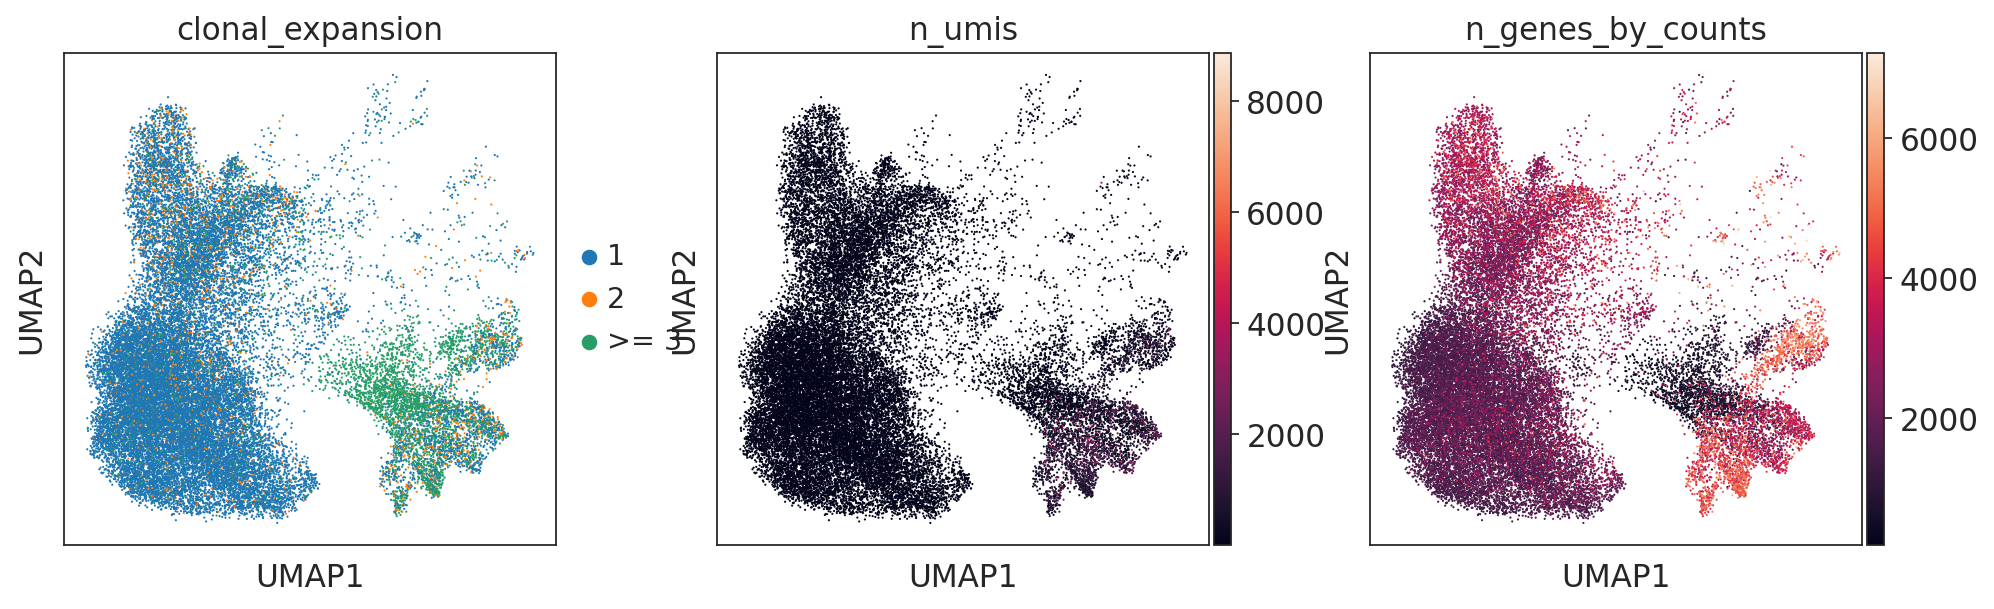

In [118]:
sc.pl.umap(adata, color=["clonal_expansion", "n_umis", "n_genes_by_counts"])

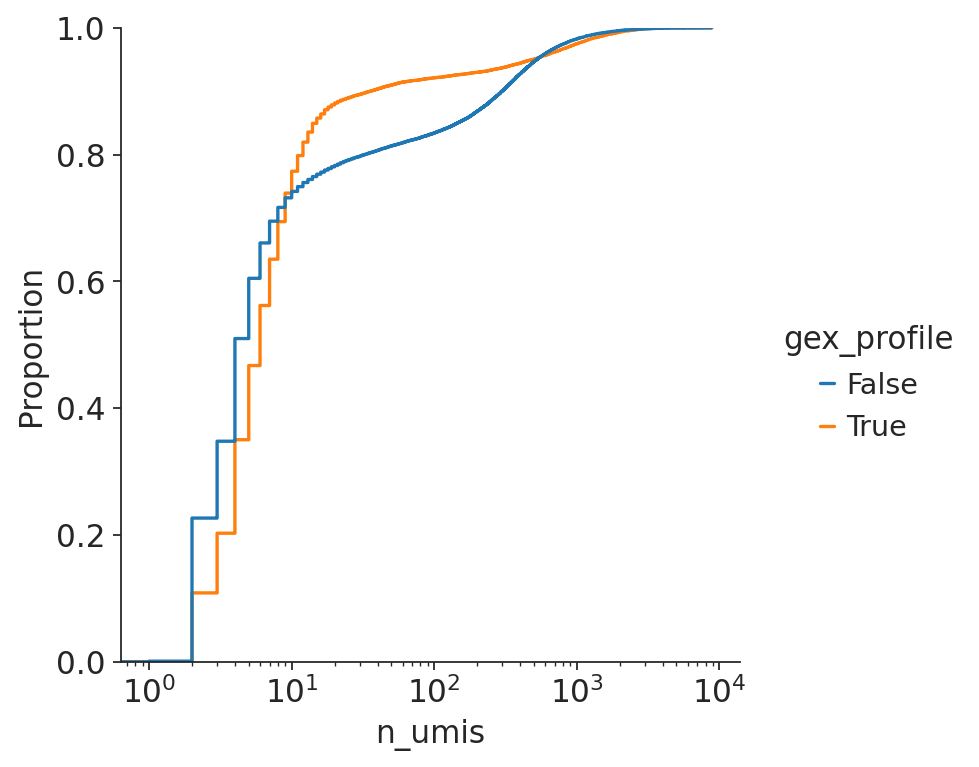

In [85]:
# Given cell, how many UMIs are do you have
df['gex_profile'] = df.cb_sample_id.isin(adata.obs.cb_sample_id)
sns.displot(data = df, x = 'n_umis', hue = 'gex_profile', kind = 'ecdf')
plt.xscale('log')

In [91]:
adata.obs.celltypist.value_counts(normalize = True)

Naive B cells                                   0.599384
Memory B cells                                  0.207338
Plasma cells                                    0.117427
Plasmablasts                                    0.033578
Tcm/Naive helper T cells                        0.011394
Age-associated B cells                          0.007109
Tem/Trm cytotoxic T cells                       0.005237
Regulatory T cells                              0.004538
Tcm/Naive cytotoxic T cells                     0.004094
Erythrophagocytic macrophages                   0.001269
HSC/MPP                                         0.001047
Classical monocytes                             0.000984
Migratory DCs                                   0.000825
Follicular helper T cells                       0.000825
Endothelial cells                               0.000793
MAIT cells                                      0.000698
CD16- NK cells                                  0.000666
Neutrophil-myeloid progenitor  

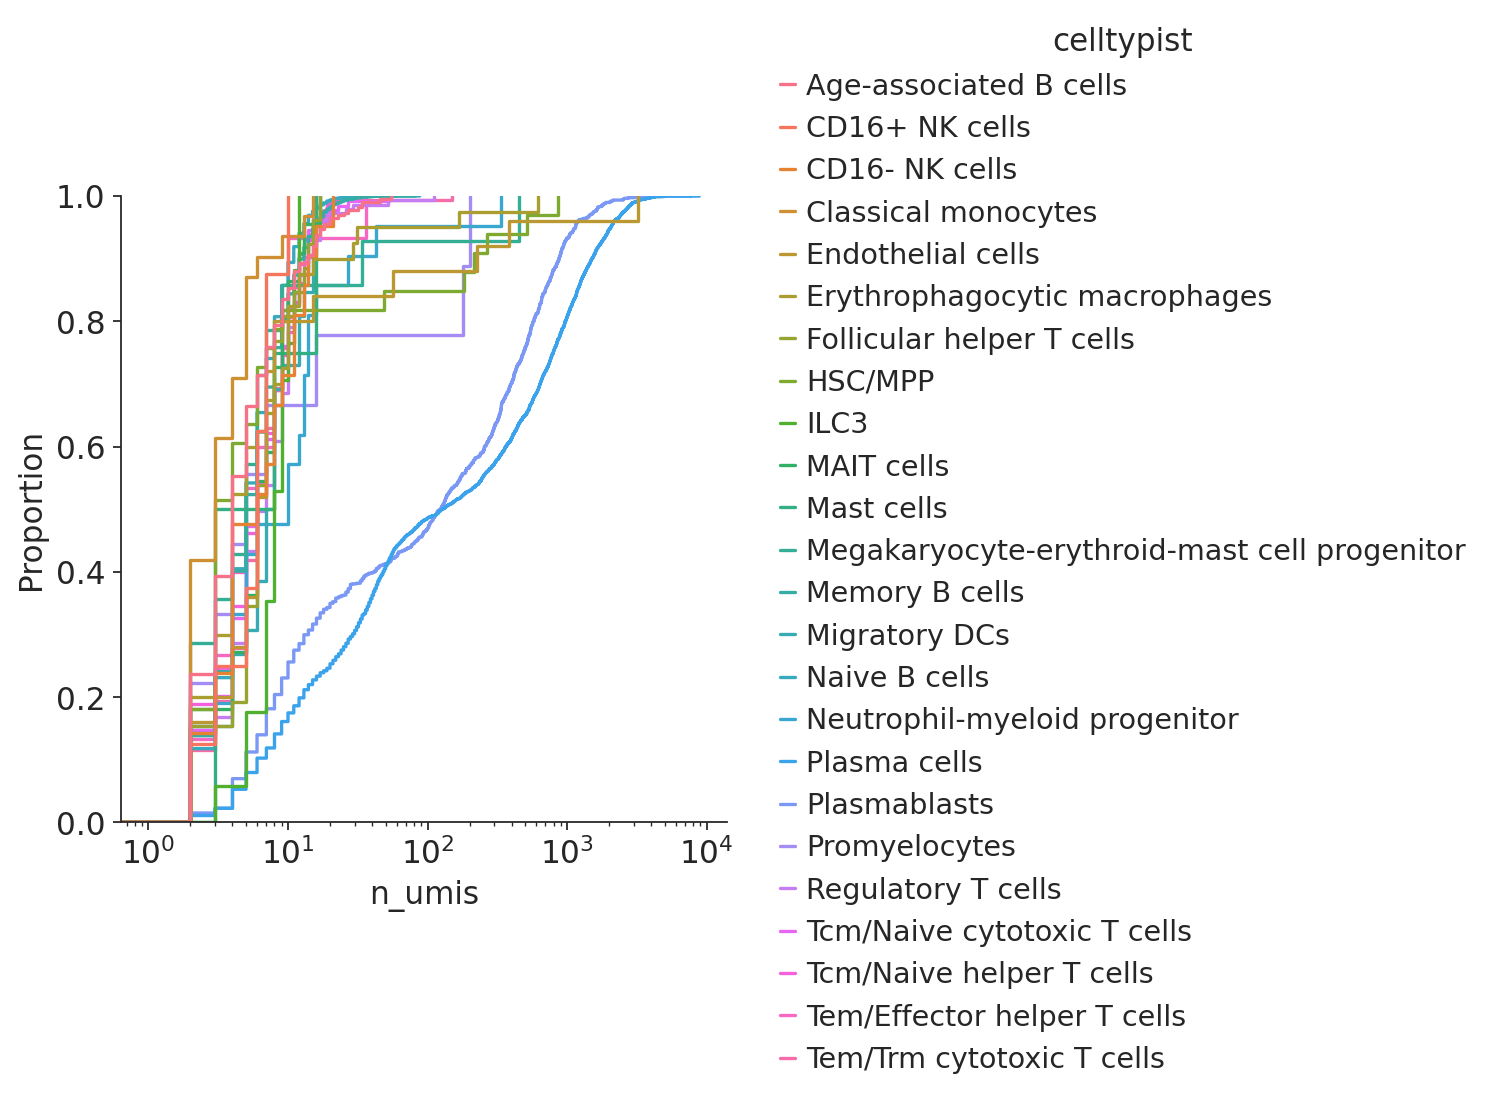

In [98]:
data = adata.obs
#data = data[data.celltypist.str.contains('B cells|Plasma')]
sns.displot(data = data, x = 'n_umis', hue = 'celltypist', kind='ecdf', log_scale=True)

Text(0.5, 1.0, 'B cells|Plasma')

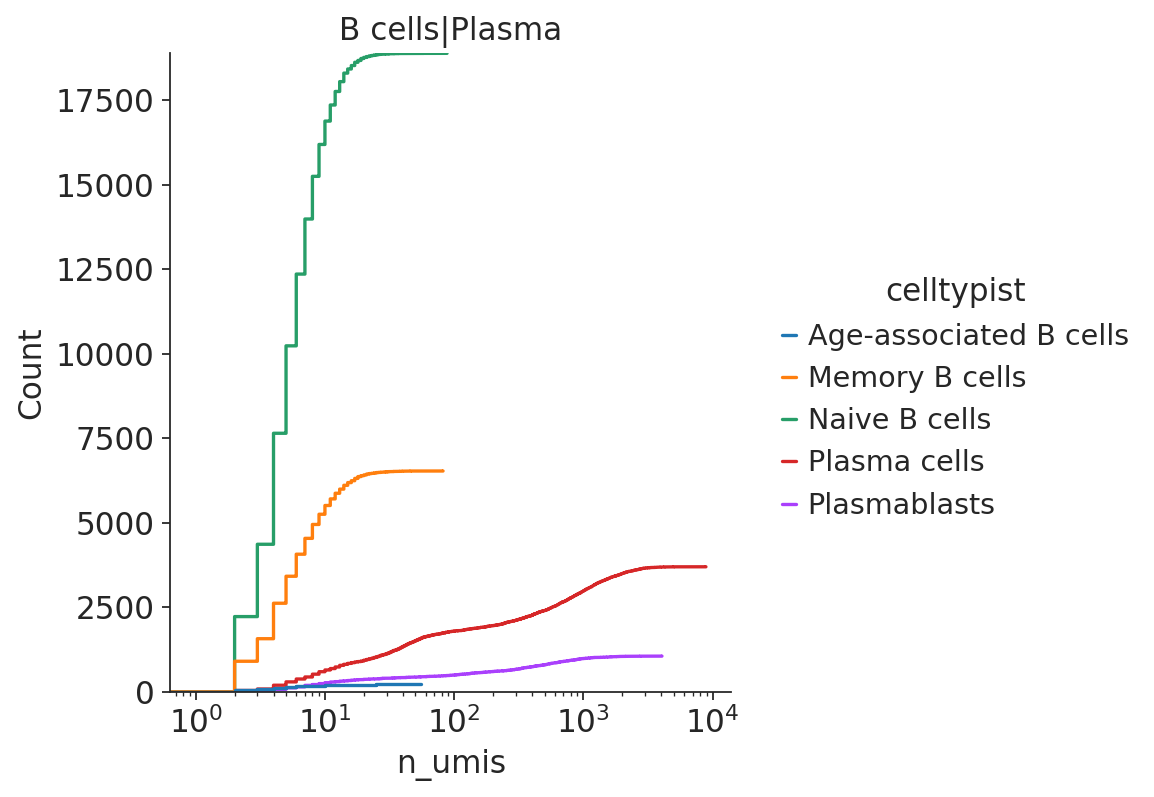

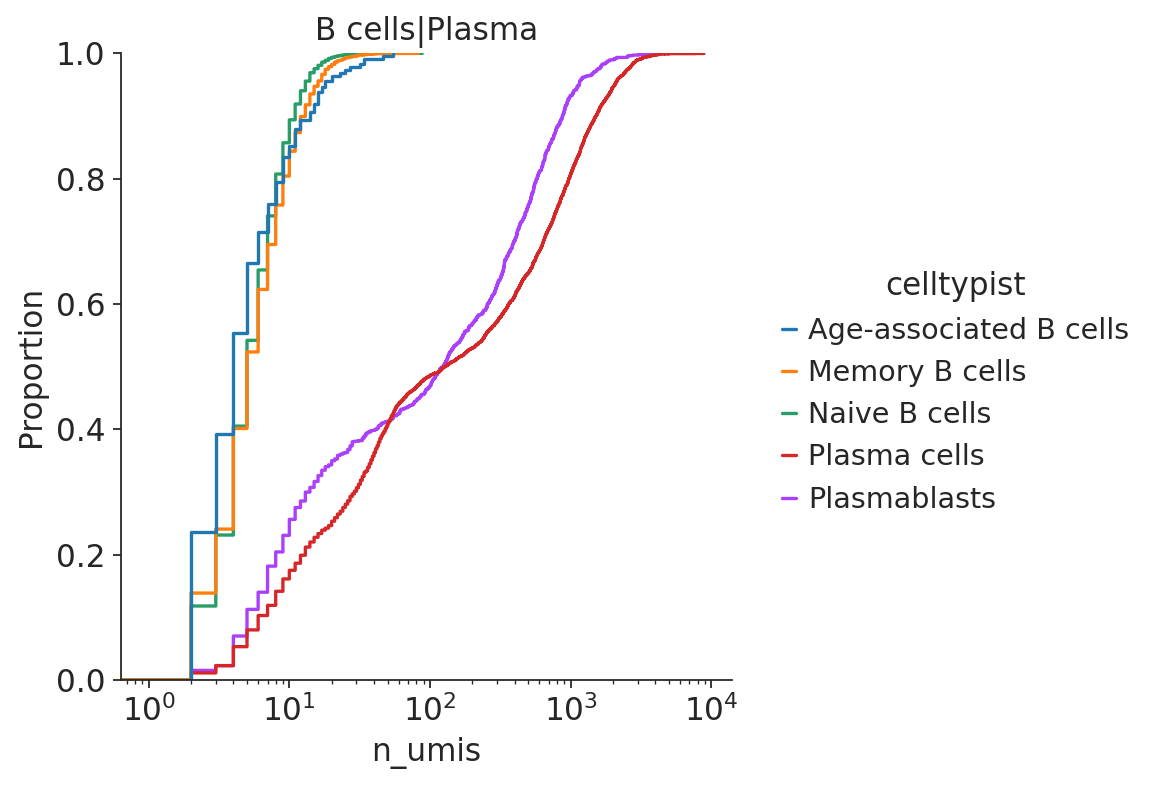

In [110]:
subset = 'B cells|Plasma'
data = adata.obs
data = data[data.celltypist.str.contains(subset)]
data.celltypist.cat.remove_unused_categories(inplace = True)
sns.displot(data = data, x = 'n_umis', hue = 'celltypist', kind='ecdf', log_scale=True, stat = 'count')
plt.title(subset)


subset = 'B cells|Plasma'
data = adata.obs
data = data[data.celltypist.str.contains(subset)]
data.celltypist.cat.remove_unused_categories(inplace = True)
sns.displot(data = data, x = 'n_umis', hue = 'celltypist', kind='ecdf', log_scale=True, stat = 'proportion')
plt.title(subset)

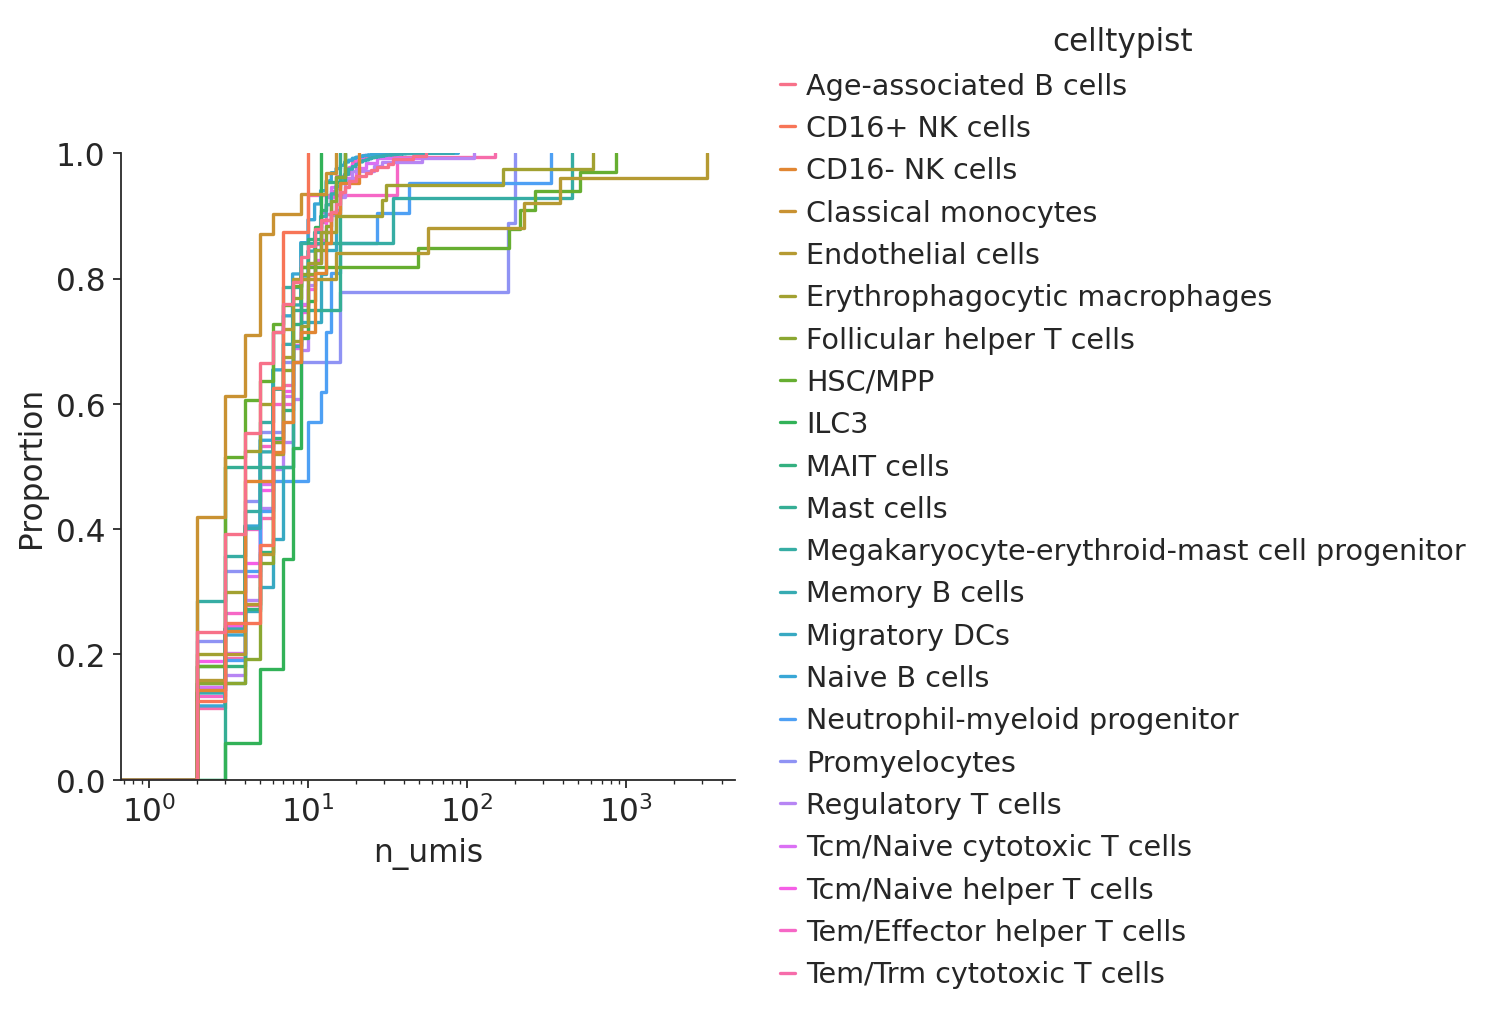

In [114]:
data = adata.obs
data = data[~data.celltypist.str.contains('Plasma')]
data.celltypist.cat.remove_unused_categories(inplace = True)
sns.displot(data = data, x = 'n_umis', hue = 'celltypist', stat='proportion', log_scale=True, kind = 'ecdf')

In [86]:
data = adata.obs[adata.obs.celltypist

tissue batch  n_genes_by_counts  log1p_n_genes_by_counts  \
cb_index                                                                        
AAACCTGAGAAAGTGG-1-0     LN     0               2810                 7.941296   
AAACCTGAGACTAAGT-1-0     LN     0               1694                 7.435438   
AAACCTGAGAGGTAGA-1-0     LN     0               2651                 7.883069   
AAACCTGAGATGGCGT-1-0     LN     0               1518                 7.325808   
AAACCTGAGTAACCCT-1-0     LN     0               2593                 7.860956   
...                     ...   ...                ...                      ...   
TTTGTCAGTTGCGCAC-1-3     BM     3                532                 6.278521   
TTTGTCATCTCCAACC-1-3     BM     3               3494                 8.159089   
TTTGTCATCTCCCTGA-1-3     BM     3               4233                 8.350902   
TTTGTCATCTCTGCTG-1-3     BM     3               1901                 7.550661   
TTTGTCATCTTTACGT-1-3     BM     3               1815                 7.504392   

                      total_counts  log1p_total_counts  total_counts_mt  \
cb_index                                                                  
AAACCTGAGAAAGTGG-1-0        9524.0            9.161675            317.0   
AAACCTGAGACTAAGT-1-0        4284.0            8.362876            162.0   
AAACCTGAGAGGTAGA-1-0        7219.0            8.884610            301.0   
AAACCTGAGATGGCGT-1-0        3441.0            8.143808            100.0   
AAACCTGAGTAACCCT-1-0        6877.0            8.836083            497.0   
...                            ...                 ...              ...   
TTTGTCAGTTGCGCAC-1-3        1266.0            7.144407             61.0   
TTTGTCATCTCCAACC-1-3       35856.0           10.487294            340.0   
TTTGTCATCTCCCTGA-1-3       29739.0           10.300248           1221.0   
TTTGTCATCTCTGCTG-1-3        4533.0            8.419360            152.0   
TTTGTCATCTTTACGT-1-3        3898.0            8.268476            142.0   

                      log1p_total_counts_mt  pct_counts_mt  n_counts  ...  \
cb_index                                                              ...   
AAACCTGAGAAAGTGG-1-0               5.762052       3.328433    9524.0  ...   
AAACCTGAGACTAAGT-1-0               5.093750       3.781513    4284.0  ...   
AAACCTGAGAGGTAGA-1-0               5.710427       4.169552    7219.0  ...   
AAACCTGAGATGGCGT-1-0               4.615120       2.906132    3441.0  ...   
AAACCTGAGTAACCCT-1-0               6.210600       7.226989    6877.0  ...   
...                                     ...            ...       ...  ...   
TTTGTCAGTTGCGCAC-1-3               4.127134       4.818326    1266.0  ...   
TTTGTCATCTCCAACC-1-3               5.831882       0.948237   35856.0  ...   
TTTGTCATCTCCCTGA-1-3               7.108244       4.105720   29739.0  ...   
TTTGTCATCTCTGCTG-1-3               5.030438       3.353188    4533.0  ...   
TTTGTCATCTTTACGT-1-3               4.962845       3.642894    3898.0  ...   

                     v_qstart v_qend v_sstart v_send       v_evalue  \
cb_index                                                              
AAACCTGAGAAAGTGG-1-0        1    285        2    286  3.440000e-118   
AAACCTGAGACTAAGT-1-0        1    285        2    286  1.500000e-129   
AAACCTGAGAGGTAGA-1-0        1    291        2    292  8.310000e-125   
AAACCTGAGATGGCGT-1-0        1    288        2    289  5.760000e-131   
AAACCTGAGTAACCCT-1-0        1    288        2    289   3.350000e-91   
...                       ...    ...      ...    ...            ...   
TTTGTCAGTTGCGCAC-1-3        1    287        2    288  1.310000e-110   
TTTGTCATCTCCAACC-1-3        1    288        2    289  4.960000e-112   
TTTGTCATCTCCCTGA-1-3        1    288        2    289   1.810000e-86   
TTTGTCATCTCTGCTG-1-3        1    287        2    288  1.520000e-129   
TTTGTCATCTTTACGT-1-3        1    288        2    289  5.760000e-131   

                                                            v_mut

<AxesSubplot:>

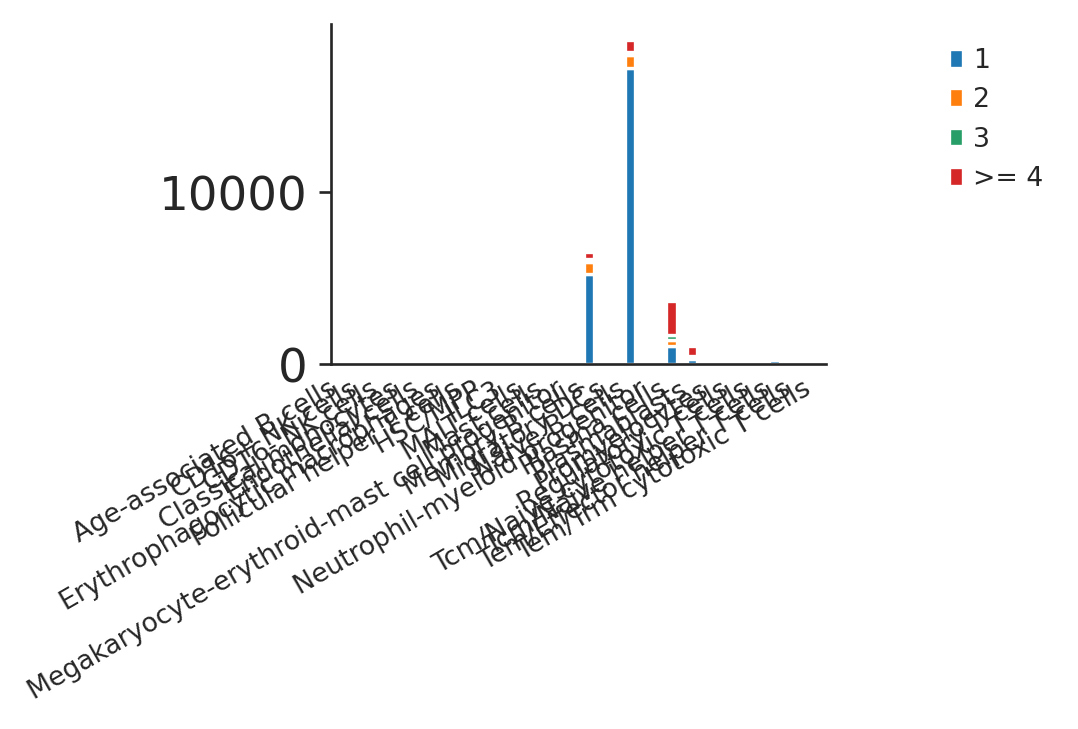

In [46]:
ir.pl.clonal_expansion(adata, groupby="celltypist", clip_at=4, normalize=False)

In [40]:
adata.obs.lineage_id.value_counts()

2         194
4350      112
6367       96
271        76
84         75
         ... 
129878      1
141266      1
36825       1
88664       1
90425       1
Name: lineage_id, Length: 26426, dtype: int64

In [ ]:
_adata = adata[adata.obs.lineage_id.isin(biglins)]

In [ ]:
_adata.obs.celltypist = _adata.obs.celltypist.cat.remove_unused_categories()

In [ ]:
_adata.obs.groupby('lineage_id').sample_id.value_counts()

In [ ]:
_adata.obs.groupby(['lineage_id', 'sample_id']).celltypist.value_counts()

In [ ]:
adata.write_h5ad('data/vdj_TBD5.h5ad')

In [ ]:
adata = sc.read_h5ad('../../data/processed_h5ad/vdj_TBD5.h5ad')

In [ ]:
adata.obs.to_csv('../../data/vdj_gex_labels.tsv', sep='\t')